In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Examining the Data

Data sets "train.csv" and "test.csv" can be downloaded from: https://www.kaggle.com/competitions/titanic/data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print('Training set shape:', train_df.shape)
print('Test set shape:', test_df.shape)
train_df.head()

Training set shape: (891, 12)
Test set shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Sex

In [3]:
femalepercent = train_df[(train_df.Sex=='female')&(train_df.Survived==1)].Sex.count()/train_df[(train_df.Sex=='female')].Sex.count()
malepercent = train_df[(train_df.Sex=='male')&(train_df.Survived==1)].Sex.count()/train_df[(train_df.Sex=='male')].Sex.count()
print('Male Passenger Surival Rate = {}%\nFemale Passenger Surival Rate = {}%'.format(round(100*malepercent,1),round(100*femalepercent,1)))

Male Passenger Surival Rate = 18.9%
Female Passenger Surival Rate = 74.2%


Female passengers have a much higher survival rate so Sex is likely an important feature for predicting survival.

## Ages

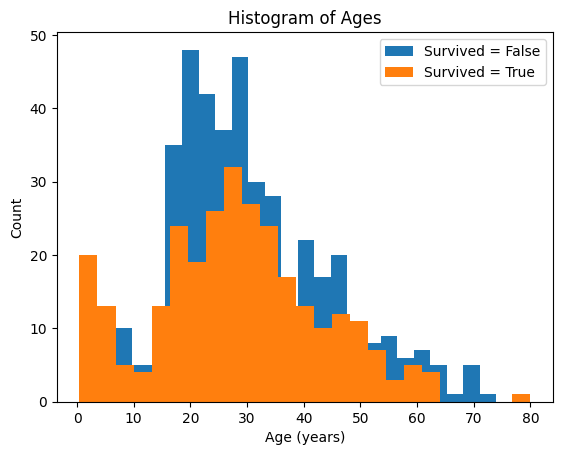

In [4]:
train_df[train_df.Survived==0].Age.hist(bins=25,grid=False)
train_df[train_df.Survived==1].Age.hist(bins=25,grid=False)
plt.legend(['Survived = False', 'Survived = True'])
plt.title('Histogram of Ages')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()

Surival probability appeares to decline with age with the exception of young children which have a higher chance of survival.

# Pclass

In [5]:
p1percent = train_df[(train_df.Pclass==1)&(train_df.Survived==1)].Pclass.count()/train_df[(train_df.Pclass==1)].Pclass.count()
p2percent = train_df[(train_df.Pclass==2)&(train_df.Survived==1)].Pclass.count()/train_df[(train_df.Pclass==2)].Pclass.count()
p3percent = train_df[(train_df.Pclass==3)&(train_df.Survived==1)].Pclass.count()/train_df[(train_df.Pclass==3)].Pclass.count()

print('1st Class Survival Rate = {}%'.format(round(p1percent*100,1)))
print('2nd Class Survival Rate = {}%'.format(round(p2percent*100,1)))
print('3rd Class Survival Rate = {}%'.format(round(p3percent*100,1)))

1st Class Survival Rate = 63.0%
2nd Class Survival Rate = 47.3%
3rd Class Survival Rate = 24.2%


## New Features

We engineer new features "Family" and "Alone" which indicate family size and whether the passenger is travelling alone respectively. These features may help predict the missing ages as well possibly being useful for predicting surival.

### Family Size

In [6]:
for df in [train_df,test_df]:
    df['Family'] = 1+df.Parch+df.SibSp

### Traveling Alone

In [7]:
for df in [train_df,test_df]:
    df['Alone'] = df.Family.apply(lambda x: 1 if x==1 else 0)
train_df[['Alone','Parch','SibSp']].head()

,Alone,Parch,SibSp
0,0,0,1
1,0,0,1
2,1,0,0
3,0,0,1
4,1,0,0


Pclass appears to have an affect on survival as well with passengers in 1st class having the highest survival rate.

# Missing Values
Some of the missing values were filled in with help from the tutorial found at: https://www.kaggle.com/code/allohvk/titanic-missing-age-imputation-tutorial-advanced.

The data has several missing values:

In [8]:
print('TRAINING SET MISSING VALUES PERCENTAGE:')
print(round(train_df.isna().sum().sort_values(ascending=False)/len(train_df)*100,1))
print('')
print('TEST SET MISSING VALUES PERCENTAGE:')
print(round(test_df.isna().sum().sort_values(ascending=False)/len(test_df)*100,1))

TRAINING SET MISSING VALUES PERCENTAGE:
Cabin          77.1
Age            19.9
Embarked        0.2
PassengerId     0.0
Survived        0.0
Pclass          0.0
Name            0.0
Sex             0.0
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
Family          0.0
Alone           0.0
dtype: float64

TEST SET MISSING VALUES PERCENTAGE:
Cabin          78.2
Age            20.6
Fare            0.2
PassengerId     0.0
Pclass          0.0
Name            0.0
Sex             0.0
SibSp           0.0
Parch           0.0
Ticket          0.0
Embarked        0.0
Family          0.0
Alone           0.0
dtype: float64


The majority of values for "Cabin" are missing. Replacing them would likely introduce too much noise.

A significant portion of the "Age" values are missing and need to be adressed. Age is likely a significant feature for determining whether a passenger survived or not.

Additionally there are missing values in "Fare" and "Embarked".

## Missing Fare

The only missing fare is for a passenger with Pclass=3 and Embarked=S. We can replace this value with the average for passengers from the same class which embarked at the same port.

In [9]:
merged_df = pd.concat([train_df,test_df])
display(merged_df[merged_df.Fare.isnull()])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Alone
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,1


We can also note that the passenger is travelling alone because Parch=SibSp=0.

One caveat we must address before we can fill in the missing Fare is we must determine the fare per person. This can be done be counting the number of passengers with the same Ticket and dividing the Fare for that Ticket by the number of people.

In [10]:
for df in [train_df, test_df, merged_df]:
    df['PeopleInTicket'] = df['Ticket'].map(merged_df['Ticket'].value_counts())
    df['FarePerPerson'] = df['Fare']/df['PeopleInTicket']

aveFarePerPersonPclass3EmbarkedS = round(train_df[(train_df.Embarked=='S') & (train_df.Pclass==3) & (train_df.PeopleInTicket==1)]['FarePerPerson'].mean(),2)
test_df.loc[test_df.Fare.isnull(),['Fare','FarePerPerson']] = aveFarePerPersonPclass3EmbarkedS
print('Average Fare for passenger in 3rd class embarking from Southampton travelling alone = ${}'.format(aveFarePerPersonPclass3EmbarkedS))

Average Fare for passenger in 3rd class embarking from Southampton travelling alone = $8.11


## Missing Embarked

Lastly we can deduce likely values for the missing values in the "Embarked" columnn.

In [11]:
display(merged_df[merged_df.Embarked.isnull()])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Alone,PeopleInTicket,FarePerPerson
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,1,2,40.0
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,1,2,40.0


Both passengers have the same Ticket so they must have departed from the same location.

In [12]:
train_df[(train_df.Pclass==1)].groupby('Embarked').agg({'FarePerPerson' : 'mean', 'Fare' : 'mean', 'PassengerId' : 'count'})

,FarePerPerson,Fare,PassengerId
Embarked,,,
C,39.179223,104.718529,85
Q,30.000000,90.000000,2
S,30.211849,70.364862,127


From the data above, it looks like C and Q are the best choices. Only two people embarked at Q and the fare is 30 so it is likely that C is the correct choice.

In [13]:
train_df.Embarked.fillna('C',inplace=True)

# Predicting the Missing Ages

We will first predict the missing age values by simply calculating the mean and median for passengers with similar features. We will then compare these predictions to several classifiers by splitting the training data into a smaller training set and test set. We consider the full training data for the ages to be rows of "train.csv" without missing ages. The ages will be grouped into several ranges which the classifiers will try to predict.

First we must extract the title from the "Name" feature.

In [14]:
train_df['Title'], test_df['Title'] = [df.Name.str.extract (' ([A-Za-z]+)\.',expand=False) for df in [train_df,test_df]]

merged_df = pd.concat([train_df,test_df])

merged_df.groupby(['Title', 'Pclass'])['Age'].agg(['mean','median','max', 'count'])

mean  median   max  count
Title    Pclass                                
Capt     1       70.000000    70.0  70.0      1
Col      1       54.000000    54.5  60.0      4
Countess 1       33.000000    33.0  33.0      1
Don      1       40.000000    40.0  40.0      1
Dona     1       39.000000    39.0  39.0      1
Dr       1       45.600000    49.0  53.0      5
         2       38.500000    38.5  54.0      2
Jonkheer 1       38.000000    38.0  38.0      1
Lady     1       48.000000    48.0  48.0      1
Major    1       48.500000    48.5  52.0      2
Master   1        6.984000     6.0  13.0      5
         2        2.757273     2.0   8.0     11
         3        6.090000     6.0  14.5     37
Miss     1       30.338983    30.0  63.0     59
         2       20.717083    20.0  50.0     48
         3       17.360874    18.0  45.0    103
Mlle     1       24.000000    24.0  24.0      2
Mme      1       24.000000    24.0  24.0      1
Mr       1       41.450758    41.5  80.0    132
         2       32.346715    30.0  70.0    137
         3       28.318910    26.0  74.0    312
Mrs      1       43.208955    45.0  76.0     67
         2       33.518519    30.5  60.0     54
         3       32.326531    31.0  63.0     49
Ms       2       28.000000    28.0  28.0      1
         3             NaN     NaN   NaN      0
Rev      2       41.250000    41.5  57.0      8
Sir      1       49.000000    49.0  49.0      1

The only "Ms" in third class must also be missing an Age causing the NaN result.

We make a dictionary to condense the various titles into smaller groups.

In [15]:
titledict = {"Capt": "Crew","Col": "Crew","Major": "Crew","Jonkheer": "Aristocrat",
             "Don": "Aristocrat", "Sir" : "Aristocrat","Dr": "Aristocrat","Rev": "Aristocrat",
             "Countess":"Aristocrat", "Mme": "Mrs", "Mlle": "Miss", "Ms": "Miss","Mr" : "Mr",
             "Mrs" : "Mrs","Miss" : "Miss","Master" : "Master","Lady" : "Aristocrat", "Dona" : "Aristocrat"}

In [16]:
train_df['Title'], test_df['Title'] = [df.Title.map(titledict) for df in [train_df, test_df]]

train_df.groupby(['Title', 'Pclass'])['Age'].agg(['mean', 'count'])

mean  count
Title      Pclass                  
Aristocrat 1       42.555556      9
           2       42.000000      8
Crew       1       56.600000      5
Master     1        5.306667      3
           2        2.258889      9
           3        5.350833     24
Miss       1       29.744681     47
           2       22.560606     33
           3       16.123188     69
Mr         1       41.580460     87
           2       32.768293     82
           3       28.724891    229
Mrs        1       40.400000     35
           2       33.682927     41
           3       33.515152     33

There is no universal Title for female children but we can use Parch to estimate the missing Age of female passengers.

In [17]:
aveMissage = round(train_df[train_df.Title=='Miss'].Age.mean())
print('Average age for "Miss" Title = {}'.format(aveMissage))

aveMissnoparentsage = round(train_df[(train_df.Title=='Miss')&(train_df.Parch==0)].Age.mean())
print('Average age for "Miss" Title without Parents = {}'.format(aveMissnoparentsage))

aveMisswithparentsage = round(train_df[(train_df.Title=='Miss')&(train_df.Parch!=0)].Age.mean())
print('Average age for "Miss" Title with Parents = {}'.format(aveMisswithparentsage))

Average age for "Miss" Title = 22
Average age for "Miss" Title without Parents = 28
Average age for "Miss" Title with Parents = 12


As suspected, the average age for females with the "Miss" Title and Parch>0 Title is much lower than the average age for females with the "Miss" Title and Parch=0.

We can create another title in the Title column "FemaleChild" to keep track of females with Parch=0 and PeopleInTicket>1.

In [18]:
for df in [train_df, test_df, merged_df]:
    df.loc[(df.Title=='Miss') & (df.Parch!=0) & (df.PeopleInTicket>1) & (df.Age<18), 'Title']="FemaleChild"

We can perform a similar analysis for the median ages.

In [19]:
medMissage = round(train_df[train_df.Title=='Miss'].Age.median())
print('Median age for "Miss" Title = {}'.format(medMissage))

medMissnoparentsage = round(train_df[(train_df.Title=='Miss')&(train_df.Parch==0)].Age.median())
print('Median age for "Miss" Title without Parents = {}'.format(medMissnoparentsage))

medMisswithparentsage = round(train_df[(train_df.Title=='Miss')&(train_df.Parch!=0)].Age.median())
print('Median age for "Miss" Title with Parents = {}'.format(medMisswithparentsage))

Median age for "Miss" Title = 24
Median age for "Miss" Title without Parents = 26
Median age for "Miss" Title with Parents = 22


The median age for passengers with the Miss title with parents is much higher than the mean.

## Convert Categorical Data to Numerical Values

Before calculating the means and medians, we convert all of the categorical data to numerical values. This way we can use the same data frame for the calcuating the means and medians as for the classifiers. We also one-hot encode the "Title" and "Embarked" features.

### Sex: female = 1, male = 0

In [20]:
for df in [train_df, test_df, merged_df]:
    df.loc[df.Sex=='male','Sex']=0
    df.loc[df.Sex=='female','Sex']=1

### Title

In [21]:
# one-hot
train_df, test_df, merged_df = [df.join(pd.get_dummies(df['Title'])) for df in [train_df, test_df, merged_df]]

for df in [train_df, test_df, merged_df]:
    df.Title.replace({'FemaleChild' : 0, 'Master' : 1, 'Miss' : 2, 'Mr' : 3,
                      'Mrs' : 4, 'Crew' : 5, 'Aristocrat' : 6},inplace=True)

### Embarked

In [22]:
# one-hot
train_df, test_df, merged_df = [df.join(pd.get_dummies(df['Embarked']))
                                for df in [train_df, test_df, merged_df]]

for df in [train_df,test_df,merged_df]:
    df.Embarked.replace({'S' : 0, 'C' : 1, 'Q' : 2},inplace=True)

In [23]:
# Use the training data without the missing values to train the classifier
feature_list = ['PassengerId','Sex','Age','Pclass','Fare','Parch',
                'SibSp','Alone','Family','Title','FemaleChild','Master',
                'Miss','Mr','Mrs','Crew','Aristocrat','S','C','Q']
agetrain_df = train_df[feature_list].dropna()

agefeatures = ['Sex','Pclass','Fare','Family','Title','FemaleChild',
               'Master','Miss','Mr','Mrs','Crew','Aristocrat','S','C','Q']
X_age = agetrain_df[agefeatures]
y_age = agetrain_df['Age']

X_agetrain, X_agetest, y_agetrain, y_agetest = train_test_split(X_age, y_age, random_state=0)

We make lookup tables for the mean and median Age given Sex, Pclass and Title.

In [24]:
lookupmean = train_df.groupby(['Pclass','Sex','Title'])['Age'].mean().reset_index()[['Sex', 'Pclass', 'Title','Age']]
lookupmean_train = pd.concat([X_agetrain,y_agetrain],axis=1).groupby(['Pclass','Sex','Title'])['Age'].mean().reset_index()[['Sex', 'Pclass', 'Title','Age']]
lookupmean_test = pd.concat([X_agetest,y_agetest],axis=1).groupby(['Pclass','Sex','Title'])['Age'].mean().reset_index()[['Sex', 'Pclass', 'Title','Age']]

lookupmean

,Sex,Pclass,Title,Age
0,0,1,1,5.306667
1,0,1,3,41.580460
2,0,1,5,56.600000
3,0,1,6,42.166667
4,1,1,0,12.600000
5,1,1,2,31.785714
6,1,1,4,40.400000
7,1,1,6,43.333333
8,0,2,1,2.258889
9,0,2,3,32.768293


In [25]:
lookupmedian = train_df.groupby(['Pclass','Sex','Title'])['Age'].median().reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
lookupmedian_train = pd.concat([X_agetrain,y_agetrain],axis=1).groupby(['Pclass','Sex','Title'])['Age'].median().reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
lookupmedian_test = pd.concat([X_agetest,y_agetest],axis=1).groupby(['Pclass','Sex','Title'])['Age'].median().reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

lookupmedian

,Sex,Pclass,Title,Age
0,0,1,1,4.0
1,0,1,3,40.0
2,0,1,5,56.0
3,0,1,6,42.0
4,1,1,0,15.0
5,1,1,2,30.0
6,1,1,4,40.0
7,1,1,6,48.0
8,0,2,1,1.0
9,0,2,3,31.0


We can fill the missing ages with the mean or median age of passengers with the same Sex, Pclass and Title.

In [26]:
def replace_age_mean(x):
    return lookupmean[(lookupmean.Pclass==x['Pclass'])&(lookupmean.Sex==x['Sex'])&(lookupmean.Title==x['Title'])]['Age'].values[0]

# Replace Missing Ages With Means
# train_df['Age'], test_df['Age'] = [df.apply(lambda x: replace_age_mean(x) if np.isnan(x['Age']) else x['Age'], axis=1) for df in [train_df, test_df]]

def replace_age_median(x):
    return lookupmedian[(lookupmedian.Pclass==x['Pclass'])&(lookupmedian.Sex==x['Sex'])&(lookupmedian.Title==x['Title'])]['Age'].values[0]

# Replace Missing Ages With Medians
# train_df['Age'], test_df['Age'] = [df.apply(lambda x: replace_age_median(x) if np.isnan(x['Age']) else x['Age'], axis=1) for df in [train_df, test_df]]


## Predict Missing Ages with a Classifier

### Fare Group

In [27]:
train_df['FareGroup'] = pd.qcut(train_df['Fare'],4)
train_df[['FareGroup','Survived']].groupby(['FareGroup']).mean()

,Survived
FareGroup,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [28]:
def group_fare(x):
    if x<=7.91: return 0
    elif (x>7.91)&(x<=14.454): return 1
    elif (x>14.454)&(x<=31.0): return 2
    else: return 3
    
for df in [train_df,test_df,merged_df, agetrain_df]:
    df['Fare'] = df.apply(lambda x: group_fare(x.Fare),axis=1)

### Age Groups

We separate ages into groups for the classifier to predict.

In [29]:
agetrain_df['Age'] = agetrain_df['Age'].astype(int)
agetrain_df['AgeGroup'] = pd.cut(agetrain_df['Age'],5)
agetrain_df

,PassengerId,Sex,Age,Pclass,Fare,Parch,SibSp,Alone,Family,Title,...,Master,Miss,Mr,Mrs,Crew,Aristocrat,S,C,Q,AgeGroup
0,1,0,22,3,0,0,1,0,2,3,...,0,0,1,0,0,0,1,0,0,"(16.0, 32.0]"
1,2,1,38,1,3,0,1,0,2,4,...,0,0,0,1,0,0,0,1,0,"(32.0, 48.0]"
2,3,1,26,3,1,0,0,1,1,2,...,0,1,0,0,0,0,1,0,0,"(16.0, 32.0]"
3,4,1,35,1,3,0,1,0,2,4,...,0,0,0,1,0,0,1,0,0,"(32.0, 48.0]"
4,5,0,35,3,1,0,0,1,1,3,...,0,0,1,0,0,0,1,0,0,"(32.0, 48.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,1,39,3,2,5,0,0,6,4,...,0,0,0,1,0,0,0,0,1,"(32.0, 48.0]"
886,887,0,27,2,1,0,0,1,1,6,...,0,0,0,0,0,1,1,0,0,"(16.0, 32.0]"
887,888,1,19,1,2,0,0,1,1,2,...,0,1,0,0,0,0,1,0,0,"(16.0, 32.0]"
889,890,0,26,1,2,0,0,1,1,3,...,0,0,1,0,0,0,0,1,0,"(16.0, 32.0]"


Converting the ages will also make it easier to compare the accuracy of calculating the means and medians to the results from the classifiers.

In [30]:
def group_age(x):
    if x<=16: return 0
    elif (x>16)&(x<=32): return 1
    elif (x>32)&(x<=48): return 2
    elif (x>48)&(x<=64): return 3
    else: return 4

# Apply to every data frame    
for df in [train_df, test_df, merged_df, agetrain_df, lookupmean, lookupmean_train, lookupmean_test, lookupmedian, lookupmedian_train, lookupmedian_test]:
    df['Age'] = df.apply(lambda x: group_age(x.Age) if pd.notnull(x.Age) else x.Age,axis=1)

In [31]:
agetrain_df[agefeatures]

,Sex,Pclass,Fare,Family,Title,FemaleChild,Master,Miss,Mr,Mrs,Crew,Aristocrat,S,C,Q
0,0,3,0,2,3,0,0,0,1,0,0,0,1,0,0
1,1,1,3,2,4,0,0,0,0,1,0,0,0,1,0
2,1,3,1,1,2,0,0,1,0,0,0,0,1,0,0
3,1,1,3,2,4,0,0,0,0,1,0,0,1,0,0
4,0,3,1,1,3,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,1,3,2,6,4,0,0,0,0,1,0,0,0,0,1
886,0,2,1,1,6,0,0,0,0,0,0,1,1,0,0
887,1,1,2,1,2,0,0,1,0,0,0,0,1,0,0
889,0,1,2,1,3,0,0,0,1,0,0,0,0,1,0


## Test and Train the Models

Test the means and medians method.

In [32]:
agefeatures = ['Sex','Pclass','Fare','Family','Title']
X_age = agetrain_df[agefeatures]
y_age = agetrain_df['Age']

X_agetrain, X_agetest, y_agetrain, y_agetest = train_test_split(X_age, y_age, random_state=0)

### Means and Medians

In [33]:
meanstrainscore = (y_agetrain==X_agetrain.apply(lambda x: replace_age_mean(x),axis=1)).sum()/len(y_agetrain)
meanstestscore = (y_agetest==X_agetest.apply(lambda x: replace_age_mean(x),axis=1)).sum()/len(y_agetest)
medstrainscore = (y_agetrain==X_agetrain.apply(lambda x: replace_age_median(x),axis=1)).sum()/len(y_agetrain)
medstestscore = (y_agetest==X_agetest.apply(lambda x: replace_age_median(x),axis=1)).sum()/len(y_agetest)

print('means fill train score = {}'.format(meanstrainscore))
print('means fill test score = {}'.format(meanstestscore))

print('medians fill train score = {}'.format(medstrainscore))
print('medians fill test score = {}'.format(medstestscore))

means fill train score = 0.5831775700934579
means fill test score = 0.5865921787709497
medians fill train score = 0.6317757009345795
medians fill test score = 0.5977653631284916


We now test the classifiers using one hot features for Title and Embarked.

In [34]:
agefeatures = ['Sex','Pclass','Fare','Family',
               'FemaleChild','Master','Miss',
               'Mr','Mrs','Crew','Aristocrat',
               'S','C','Q']
X_age = agetrain_df[agefeatures]
y_age = agetrain_df['Age']

X_agetrain, X_agetest, y_agetrain, y_agetest = train_test_split(X_age, y_age, random_state=0)

We will scan over the hyperparameters and attempt to approximately tune them to the optimal values which maximize the test score while minimizing the difference between the training and test scores. We then run cross-validation for the choice of hyperparameters.

### Logistic Regression

In [35]:
scaler = MinMaxScaler()
X_agetrain_scaled = scaler.fit_transform(X_agetrain)
X_agetest_scaled = scaler.transform(X_agetest)
X_age_scaled = scaler.transform(X_age)

agelogreg = LogisticRegression(C=100,max_iter=1000)
agelogreg.fit(X_agetrain_scaled, y_agetrain)
y_pred = agelogreg.predict(X_agetest_scaled)


param_range = [0.01,0.1,1,10,100,250]
agetrain_scores, agetest_scores = validation_curve(LogisticRegression(max_iter=1000), 
                                             X_age, 
                                             y_age, 
                                             param_name="C", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)
for i in range(len(param_range)):
    if i%1==0:
        print('C = {}, train score = {}, test score = {}'.format(param_range[i],np.mean(agetrain_scores,axis=1)[i],np.mean(agetest_scores,axis=1)[i]))
        

agelogtrainscore = round(agelogreg.score(X_agetrain_scaled, y_agetrain) * 100, 2)
agelogtestscore = round(agelogreg.score(X_agetest_scaled, y_agetest) * 100, 2)
print('train score = {}%'.format(agelogtrainscore))
print('test score = {}%'.format(agelogtestscore))

cv_scores_agelog = cross_val_score(agelogreg, X_agetrain_scaled, y_agetrain)

print('Logistic Regression Cross-validation scores (3-fold):', cv_scores_agelog)
print('Mean Logistic Regression cross-validation score (3-fold): {:.3f}'.format(np.mean(cv_scores_agelog)))        
        
agecoeff_df = pd.DataFrame(X_agetrain[agefeatures].columns)
agecoeff_df.columns = ['Feature']
agecoeff_df["Correlation"] = pd.Series(agelogreg.coef_[0])

agecoeff_df.sort_values(by='Correlation', ascending=False)        

C = 0.01, train score = 0.5497198879551821, test score = 0.5378151260504201
C = 0.1, train score = 0.6295518207282913, test score = 0.6022408963585434
C = 1, train score = 0.634453781512605, test score = 0.5994397759103641
C = 10, train score = 0.6330532212885154, test score = 0.6022408963585434
C = 100, train score = 0.6337535014005602, test score = 0.6022408963585434
C = 250, train score = 0.6337535014005602, test score = 0.6022408963585434
train score = 62.43%
test score = 60.89%
Logistic Regression Cross-validation scores (3-fold): [0.57943925 0.59813084 0.59813084 0.56074766 0.55140187]
Mean Logistic Regression cross-validation score (3-fold): 0.578


,Feature,Correlation
4,FemaleChild,5.879231
5,Master,5.597144
1,Pclass,4.421223
3,Family,1.992826
2,Fare,1.294039
13,Q,0.436995
0,Sex,0.317365
12,C,0.107023
6,Miss,-0.138243
11,S,-0.688116


## Support Vector Machines

### Linear Support Vector Machine

In [36]:
from sklearn.svm import SVC

ageclf = SVC(kernel = 'linear', C=100).fit(X_agetrain_scaled, y_agetrain)

param_range = [0.01,0.05,0.1,0.5,1.0,5,10,50,100,250]
agetrain_scores, agetest_scores = validation_curve(SVC(kernel='linear'), 
                                             X_age_scaled, 
                                             y_age, 
                                             param_name="C", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)

for i in range(len(param_range)):
    if i%1==0:
        print('C = {}, train score = {}, test score = {}'.format(param_range[i],
                                                                 np.mean(agetrain_scores,axis=1)[i],
                                                                 np.mean(agetest_scores,axis=1)[i]))
        
ageclftrainscore = ageclf.score(X_agetrain_scaled,y_agetrain)
print('train score = {}'.format(ageclftrainscore))

ageclftestscore = ageclf.score(X_agetest_scaled,y_agetest)
print('test score = {}'.format(ageclftestscore))

cv_scores_agelinSVC = cross_val_score(ageclf, X_age_scaled, y_age)

print('linear SVC Cross-validation scores (3-fold):', cv_scores_agelinSVC)
print('Mean linear SVC cross-validation score (3-fold): {:.3f}'.format(np.mean(cv_scores_agelinSVC)))        

C = 0.01, train score = 0.48739495798319327, test score = 0.48739495798319327
C = 0.05, train score = 0.5896358543417367, test score = 0.5896358543417367
C = 0.1, train score = 0.5896358543417367, test score = 0.5896358543417367
C = 0.5, train score = 0.6253501400560224, test score = 0.6050420168067226
C = 1.0, train score = 0.6225490196078431, test score = 0.6008403361344538
C = 5, train score = 0.6239495798319328, test score = 0.6022408963585434
C = 10, train score = 0.6281512605042017, test score = 0.5980392156862745
C = 50, train score = 0.6260504201680672, test score = 0.6064425770308123
C = 100, train score = 0.626750700280112, test score = 0.6106442577030812
C = 250, train score = 0.6281512605042017, test score = 0.6106442577030812
train score = 0.6149532710280374
test score = 0.5698324022346368
linear SVC Cross-validation scores (3-fold): [0.57342657 0.58741259 0.60839161 0.62237762 0.6056338 ]
Mean linear SVC cross-validation score (3-fold): 0.599


## Kernelized Support Vector Machines

### RBF Kernel

In [37]:
from sklearn.svm import SVC

ageclf = SVC(kernel='rbf',C=1.389495, gamma=7.196857).fit(X_agetrain_scaled, y_agetrain)

def clf_agetrain_fit_score(this_gamma,this_C):
    ageclf_fit = SVC(kernel = 'rbf', gamma = this_gamma, C = this_C).fit(X_agetrain_scaled, y_agetrain)
    return ageclf_fit.score(X_agetrain_scaled,y_agetrain)

def clf_agetest_fit_score(this_gamma,this_C):
    ageclf_fit = SVC(kernel = 'rbf', gamma = this_gamma, C = this_C).fit(X_agetrain_scaled, y_agetrain)
    return ageclf_fit.score(X_agetest_scaled,y_agetest)
    
gamma_range = np.logspace(-2, 3, 8)
C_range = np.logspace(-2, 3, 8)
cols = pd.MultiIndex.from_tuples(zip(['gamma']*len(gamma_range),gamma_range))
multi_index = pd.MultiIndex.from_tuples(zip(['C']*len(C_range),C_range))
styles = [dict(selector="caption", props=[ ("font-size", "150%"), ("color","black")])]
    
agetrain_array = np.array([[clf_agetrain_fit_score(gamma,C) for gamma in gamma_range] for C in C_range])
agetrain_validation_df = pd.DataFrame(agetrain_array,index=multi_index ,columns = cols)

agetest_array = np.array([[clf_agetest_fit_score(gamma,C) for gamma in gamma_range] for C in C_range])
agetest_validation_df = pd.DataFrame(agetest_array,index=multi_index ,columns = cols)

display(agetrain_validation_df.style.set_caption('Training Scores').set_table_styles(styles))
display(agetest_validation_df.style.set_caption('Test Scores').set_table_styles(styles))


ageclftrainscore = ageclf.score(X_agetrain_scaled,y_agetrain)
print('train score = {}'.format(ageclftrainscore))

ageclftestscore = ageclf.score(X_agetest_scaled,y_agetest)
print('test score = {}'.format(ageclftestscore))

cv_scores_agerbfSVC = cross_val_score(ageclf, X_age_scaled, y_age)

print('RBF SVC Cross-validation scores (3-fold):', cv_scores_agerbfSVC)
print('Mean RBF SVC cross-validation score (3-fold): {:.3f}'.format(np.mean(cv_scores_agerbfSVC)))

train score = 0.7046728971962617
test score = 0.6201117318435754
RBF SVC Cross-validation scores (3-fold): [0.60839161 0.66433566 0.65734266 0.58741259 0.59859155]
Mean RBF SVC cross-validation score (3-fold): 0.623


## K Nearest Neighbors

In [38]:
ageknn = KNeighborsClassifier(n_neighbors = 5)
ageknn.fit(X_agetrain_scaled,y_agetrain)

param_range = [1,3,5,7,10,25,50,100]
agetrain_scores, agetest_scores = validation_curve(KNeighborsClassifier(), 
                                             X_age_scaled, 
                                             y_age, 
                                             param_name="n_neighbors", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)

for i in range(len(param_range)):
    if i%1==0:
        print('n_neighbors = {}, train score = {}, test score = {}'.format(param_range[i],
                                                                           np.mean(agetrain_scores,axis=1)[i],
                                                                           np.mean(agetest_scores,axis=1)[i]))
        
ageknntrainscore = ageclf.score(X_agetrain_scaled,y_agetrain)
print('train score = {}'.format(ageknntrainscore))

ageknntestscore = ageclf.score(X_agetest_scaled,y_agetest)
print('test score = {}'.format(ageknntestscore))

cv_scores_ageknn = cross_val_score(ageknn, X_age_scaled, y_age)

print('KNN Cross-validation scores (3-fold):', cv_scores_ageknn)
print('Mean KNN cross-validation score (3-fold): {:.3f}'.format(np.mean(cv_scores_ageknn)))        

n_neighbors = 1, train score = 0.6477591036414565, test score = 0.5154061624649859
n_neighbors = 3, train score = 0.6526610644257703, test score = 0.5700280112044819
n_neighbors = 5, train score = 0.6715686274509803, test score = 0.6176470588235294
n_neighbors = 7, train score = 0.6645658263305322, test score = 0.6134453781512605
n_neighbors = 10, train score = 0.65406162464986, test score = 0.6120448179271709
n_neighbors = 25, train score = 0.6288515406162465, test score = 0.6120448179271709
n_neighbors = 50, train score = 0.6134453781512605, test score = 0.6050420168067228
n_neighbors = 100, train score = 0.49859943977591037, test score = 0.49719887955182074
train score = 0.7046728971962617
test score = 0.6201117318435754
KNN Cross-validation scores (3-fold): [0.59440559 0.61538462 0.64335664 0.62237762 0.59859155]
Mean KNN cross-validation score (3-fold): 0.615


## Random Forest Classifier

In [39]:
ageclf = RandomForestClassifier(n_estimators=100,max_depth=5)
ageclf.fit(X_agetrain,y_agetrain)

age_importances = pd.DataFrame({'Feature' : X_age.columns , 'Importance' :  ageclf.feature_importances_})
print(age_importances)

param_range = np.arange(1, 11, 1)
agetrain_scores, agetest_scores = validation_curve(RandomForestClassifier(random_state=0), 
                                             X_age, 
                                             y_age, 
                                             param_name="max_depth", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)
for i in range(len(param_range)):
    if i%1==0:
        print('max_depth = {}, train score = {}, test score = {}'.format(param_range[i],
                                                                         np.mean(agetrain_scores,axis=1)[i],
                                                                         np.mean(agetest_scores,axis=1)[i]))
        
ageclftrainscore = ageclf.score(X_agetrain,y_agetrain)
print('train score = {}'.format(ageclftrainscore))

ageclftestscore = ageclf.score(X_agetest,y_agetest)
print('test score = {}'.format(ageclftestscore))

cv_scores_ageRFC = cross_val_score(ageclf, X_age, y_age)

print('RFC Cross-validation scores (3-fold):', cv_scores_ageRFC)
print('Mean RFC cross-validation score (3-fold): {:.3f}'.format(np.mean(cv_scores_ageRFC)))        

        Feature  Importance
0           Sex    0.028361
1        Pclass    0.111786
2          Fare    0.107555
3        Family    0.117488
4   FemaleChild    0.190930
5        Master    0.221546
6          Miss    0.056831
7            Mr    0.041687
8           Mrs    0.050754
9          Crew    0.012875
10   Aristocrat    0.008021
11            S    0.021887
12            C    0.022393
13            Q    0.007887
max_depth = 1, train score = 0.5210084033613445, test score = 0.5168067226890756
max_depth = 2, train score = 0.5903361344537815, test score = 0.5840336134453782
max_depth = 3, train score = 0.6099439775910365, test score = 0.5966386554621849
max_depth = 4, train score = 0.6302521008403361, test score = 0.6064425770308123
max_depth = 5, train score = 0.665266106442577, test score = 0.623249299719888
max_depth = 6, train score = 0.6862745098039215, test score = 0.623249299719888
max_depth = 7, train score = 0.700280112044818, test score = 0.6218487394957983
max_depth = 8, tr

In [40]:
classifiers = ['Logistic Regression','Linear Support Vector Machine',
               'RBF Support Vector Machine','K Nearest Neighbors',
               'Random Forest Classifier']
mean_scores = [np.mean(cv_scores_agelog),np.mean(cv_scores_agelinSVC),
               np.mean(cv_scores_agerbfSVC),np.mean(cv_scores_ageknn),
               np.mean(cv_scores_ageRFC)]
pd.DataFrame({'Mean cross-validation score': mean_scores},index=classifiers).sort_values('Mean cross-validation score',ascending=False)

,Mean cross-validation score
Random Forest Classifier,0.626051
RBF Support Vector Machine,0.623215
K Nearest Neighbors,0.614823
Linear Support Vector Machine,0.599448
Logistic Regression,0.577570


The RFC seems to perform the best compared to the other classifiers and the simple means and medians model. We pick the RFC and train the model with the full training set with Age values.

In [41]:
ageclf.fit(X_age,y_age)

RandomForestClassifier(max_depth=5)

## Age Prediction

In [42]:
age_train_prediction = ageclf.predict(train_df[train_df.Age.isnull()][agefeatures])
age_train_index = train_df[train_df.Age.isnull()].index
age_train_prediction_df = pd.DataFrame({'Age' : age_train_prediction},index=age_train_index)

age_test_prediction = ageclf.predict(test_df[test_df.Age.isnull()][agefeatures])
age_test_index = test_df[test_df.Age.isnull()].index
age_test_prediction_df = pd.DataFrame({'Age' : age_test_prediction},index=age_test_index)

train_df.loc[train_df.Age.isnull(),'Age']=age_train_prediction_df.Age
test_df.loc[test_df.Age.isnull(),'Age']=age_test_prediction_df.Age

## Age\*Pclass

We engineer a new feature which accounts for the passengers age and class. From the data we can see that young children and upper class passengers ahd a greater survival rate so Age\*Pclass may be a useful feature to consider.

In [43]:
train_df['Age*Pclass'], test_df['Age*Pclass'] = [df.Age*df.Pclass for df in[train_df,test_df]]

# Predict Survival

Now that we have filled in the missing values we can predict whether passengers survive or not. To test our models we split the training data before training the model on the full training data set.

As with the age predictions we scan over the hyperparameters in an attempt to find the best choice and perform cross-validation for that choice.

In [44]:
features = ['Sex','Pclass','Age','Fare','Family','Age*Pclass']

X = train_df[features]
y = train_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

We test several classifiers and choose the one which yeilds the best results.

## Logistic Regression

In [45]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

logreg = LogisticRegression(C=10)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)


param_range = [0.01,0.1,1,10,100]
train_scores, test_scores = validation_curve(LogisticRegression(max_iter=1000), 
                                             X, 
                                             y, 
                                             param_name="C", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)
for i in range(len(param_range)):
    if i%1==0:
        print('C = {}, train score = {}, test score = {}'.format(param_range[i],
                                                                 np.mean(train_scores,axis=1)[i],
                                                                 np.mean(test_scores,axis=1)[i]))
        

logtrainscore = round(logreg.score(X_train_scaled, y_train) * 100, 2)
logtestscore = round(logreg.score(X_test_scaled, y_test) * 100, 2)
print('train score = {}%'.format(logtrainscore))
print('test score = {}%'.format(logtestscore))

cv_scores_log = cross_val_score(logreg, X_train_scaled, y_train, cv=3)

print('Logistic Regression Cross-validation scores (3-fold):', cv_scores_log)
print('Mean Logistic Regression cross-validation score (3-fold): {:.3f}'.format(np.mean(cv_scores_log)))        
        
coeff_df = pd.DataFrame(X_train[features].columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

C = 0.01, train score = 0.7542087542087542, test score = 0.7396184062850729
C = 0.1, train score = 0.787317620650954, test score = 0.7643097643097643
C = 1, train score = 0.7912457912457912, test score = 0.7867564534231201
C = 10, train score = 0.7918069584736251, test score = 0.787878787878788
C = 100, train score = 0.7918069584736251, test score = 0.787878787878788
train score = 79.64%
test score = 80.27%
Logistic Regression Cross-validation scores (3-fold): [0.76233184 0.77130045 0.7972973 ]
Mean Logistic Regression cross-validation score (3-fold): 0.777


,Feature,Correlation
0,Sex,2.756210
3,Fare,0.354974
2,Age,-1.299619
1,Pclass,-1.584212
5,Age*Pclass,-2.344628
4,Family,-2.588502


## Support Vector Machines

### Linear Support Vector Machine

In [46]:
from sklearn.svm import SVC

clf = SVC(kernel = 'linear', C=1.0).fit(X_train_scaled, y_train)

param_range = [0.01,0.05,0.1,0.5,1.0,5,10,50,100]
train_scores, test_scores = validation_curve(SVC(kernel='linear'), 
                                             X_scaled, 
                                             y, 
                                             param_name="C", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)

for i in range(len(param_range)):
    if i%1==0:
        print('C = {}, train score = {}, test score = {}'.format(param_range[i],
                                                                 np.mean(train_scores,axis=1)[i],
                                                                 np.mean(test_scores,axis=1)[i]))
        
clftrainscore = clf.score(X_train_scaled,y_train)
print('train score = {}'.format(clftrainscore))

clftestscore = clf.score(X_test_scaled,y_test)
print('test score = {}'.format(clftestscore))

cv_scores_linSVC = cross_val_score(clf, X_scaled, y, cv =3)

print('linear SVC Cross-validation scores (3-fold):', cv_scores_linSVC)
print('Mean linear SVC cross-validation score (3-fold): {:.3f}'.format(np.mean(cv_scores_linSVC)))        

C = 0.01, train score = 0.7817059483726151, test score = 0.7800224466891134
C = 0.05, train score = 0.7867564534231201, test score = 0.7867564534231201
C = 0.1, train score = 0.7867564534231201, test score = 0.7867564534231201
C = 0.5, train score = 0.7867564534231201, test score = 0.7867564534231201
C = 1.0, train score = 0.7867564534231201, test score = 0.7867564534231201
C = 5, train score = 0.7867564534231201, test score = 0.7867564534231201
C = 10, train score = 0.7867564534231201, test score = 0.7867564534231201
C = 50, train score = 0.7867564534231201, test score = 0.7867564534231201
C = 100, train score = 0.7867564534231201, test score = 0.7867564534231201
train score = 0.7889221556886228
test score = 0.7802690582959642
linear SVC Cross-validation scores (3-fold): [0.78787879 0.8013468  0.77104377]
Mean linear SVC cross-validation score (3-fold): 0.787


## Kernelized Support Vector Machines

### RBF Kernel

In [47]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf',C=1.389495, gamma= 7.196857).fit(X_train_scaled, y_train)

def clf_train_fit_score(this_gamma,this_C):
    clf_fit = SVC(kernel = 'rbf', gamma = this_gamma, C = this_C).fit(X_train_scaled, y_train)
    return clf_fit.score(X_train_scaled,y_train)

def clf_test_fit_score(this_gamma,this_C):
    clf_fit = SVC(kernel = 'rbf', gamma = this_gamma, C = this_C).fit(X_train_scaled, y_train)
    return clf_fit.score(X_test_scaled,y_test)
    
gamma_range = np.logspace(-2, 3, 8)
C_range = np.logspace(-2, 3, 8)
cols = pd.MultiIndex.from_tuples(zip(['gamma']*len(gamma_range),gamma_range))
multi_index = pd.MultiIndex.from_tuples(zip(['C']*len(C_range),C_range))

styles = [dict(selector="caption", props=[ ("font-size", "150%"), ("color","black")])]
    
train_array = np.array([[clf_train_fit_score(gamma,C) for gamma in gamma_range] for C in C_range])
train_validation_df = pd.DataFrame(train_array,index=multi_index ,columns = cols)

test_array = np.array([[clf_test_fit_score(gamma,C) for gamma in gamma_range] for C in C_range])
test_validation_df = pd.DataFrame(test_array,index=multi_index ,columns = cols)

display(train_validation_df.style.set_caption('Training Scores').set_table_styles(styles))
display(test_validation_df.style.set_caption('Test Scores').set_table_styles(styles))


clftrainscore = clf.score(X_train_scaled,y_train)
print('train score = {}'.format(clftrainscore))

clftestscore = clf.score(X_test_scaled,y_test)
print('test score = {}'.format(clftestscore))

cv_scores_rbfSVC = cross_val_score(clf, X_scaled, y, cv =3)

print('RBF SVC Cross-validation scores (3-fold):', cv_scores_rbfSVC)
print('Mean RBF SVC cross-validation score (3-fold): {:.3f}'.format(np.mean(cv_scores_rbfSVC)))

train score = 0.844311377245509
test score = 0.8385650224215246
RBF SVC Cross-validation scores (3-fold): [0.80808081 0.81481481 0.80808081]
Mean RBF SVC cross-validation score (3-fold): 0.810


## K Nearest Neighbors

In [48]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train_scaled,y_train)

param_range = [1,3,5,7,10,12,25,50,100]
train_scores, test_scores = validation_curve(KNeighborsClassifier(), 
                                             X_scaled, 
                                             y, 
                                             param_name="n_neighbors", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)

for i in range(len(param_range)):
    if i%1==0:
        print('n_neighbors = {}, train score = {}, test score = {}'.format(param_range[i],
                                                                           np.mean(train_scores,axis=1)[i],
                                                                           np.mean(test_scores,axis=1)[i]))
        
knntrainscore = clf.score(X_train_scaled,y_train)
print('train score = {}'.format(knntrainscore))

knntestscore = clf.score(X_test_scaled,y_test)
print('test score = {}'.format(knntestscore))

cv_scores_knn = cross_val_score(knn, X_scaled, y, cv = 3)

print('KNN Cross-validation scores (3-fold):', cv_scores_knn)
print('Mean KNN cross-validation score (3-fold): {:.3f}'.format(np.mean(cv_scores_knn)))        

n_neighbors = 1, train score = 0.8187429854096521, test score = 0.7542087542087542
n_neighbors = 3, train score = 0.8462401795735129, test score = 0.7991021324354657
n_neighbors = 5, train score = 0.8372615039281706, test score = 0.7856341189674523
n_neighbors = 7, train score = 0.8423120089786756, test score = 0.8047138047138048
n_neighbors = 10, train score = 0.8294051627384961, test score = 0.8103254769921436
n_neighbors = 12, train score = 0.8299663299663299, test score = 0.8047138047138048
n_neighbors = 25, train score = 0.8170594837261503, test score = 0.7923681257014591
n_neighbors = 50, train score = 0.8007856341189674, test score = 0.7912457912457912
n_neighbors = 100, train score = 0.7884399551066218, test score = 0.7867564534231201
train score = 0.844311377245509
test score = 0.8385650224215246
KNN Cross-validation scores (3-fold): [0.79461279 0.83164983 0.8047138 ]
Mean KNN cross-validation score (3-fold): 0.810


## Random Forest Classifier

In [49]:
clf = RandomForestClassifier(n_estimators=100,max_depth=5)
clf.fit(X_train,y_train)

importances = pd.DataFrame({'Feature' : X.columns , 'Importance' :  clf.feature_importances_})
display(importances)

param_range = np.arange(1, 11, 1)
train_scores, test_scores = validation_curve(RandomForestClassifier(random_state=0), 
                                             X, 
                                             y, 
                                             param_name="max_depth", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)
for i in range(len(param_range)):
    if i%1==0:
        print('max_depth = {}, train score = {}, test score = {}'.format(param_range[i],
                                                                         np.mean(train_scores,axis=1)[i],
                                                                         np.mean(test_scores,axis=1)[i]))
        
clftrainscore = clf.score(X_train,y_train)
print('train score = {}'.format(clftrainscore))

clftestscore = clf.score(X_test,y_test)
print('test score = {}'.format(clftestscore))

cv_scores_RFC = cross_val_score(clf, X, y, cv =3)

print('RFC Cross-validation scores (3-fold):', cv_scores_RFC)
print('Mean RFC cross-validation score (3-fold): {:.3f}'.format(np.mean(cv_scores_RFC)))   

,Feature,Importance
0,Sex,0.497383
1,Pclass,0.148911
2,Age,0.049924
3,Fare,0.081436
4,Family,0.112607
5,Age*Pclass,0.109738


max_depth = 1, train score = 0.7682379349046015, test score = 0.7676767676767677
max_depth = 2, train score = 0.8047138047138048, test score = 0.7991021324354657
max_depth = 3, train score = 0.8164983164983165, test score = 0.8002244668911335
max_depth = 4, train score = 0.8367003367003368, test score = 0.8024691358024691
max_depth = 5, train score = 0.8456790123456791, test score = 0.8125701459034792
max_depth = 6, train score = 0.8540965207631874, test score = 0.8103254769921437
max_depth = 7, train score = 0.8602693602693603, test score = 0.8114478114478114
max_depth = 8, train score = 0.8641975308641975, test score = 0.8103254769921436
max_depth = 9, train score = 0.8647586980920314, test score = 0.8080808080808081
max_depth = 10, train score = 0.8664421997755332, test score = 0.8035914702581369
train score = 0.8398203592814372
test score = 0.820627802690583
RFC Cross-validation scores (3-fold): [0.80808081 0.81144781 0.81144781]
Mean RFC cross-validation score (3-fold): 0.810


In [50]:
classifiers = ['Logistic Regression','Linear Support Vector Machine',
               'RBF Support Vector Machine','K Nearest Neighbors',
               'Random Forest Classifier']
mean_scores = [np.mean(cv_scores_log),np.mean(cv_scores_linSVC),
               np.mean(cv_scores_rbfSVC),np.mean(cv_scores_knn),
               np.mean(cv_scores_RFC)]
pd.DataFrame({'Mean cross-validation score': mean_scores},index=classifiers).sort_values('Mean cross-validation score',ascending=False)

,Mean cross-validation score
RBF Support Vector Machine,0.810325
K Nearest Neighbors,0.810325
Random Forest Classifier,0.810325
Linear Support Vector Machine,0.786756
Logistic Regression,0.776977


# Submission

In [51]:
# Train the model with the full training set and make predictions for the test set

X_train = train_df[features]
y_train = train_df['Survived']

X_test = test_df[features]

# We choose the Random Forest Classifier as an example
clf = RandomForestClassifier(n_estimators=100, max_depth=5)
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5)

In [52]:
submission_df = pd.DataFrame(pd.Series(clf.predict(X_test)),columns=['Survived'])
submission_df['PassengerId'] = test_df['PassengerId']
submission_df = submission_df[['PassengerId','Survived']]
submission_df.to_csv('submission.csv',index=False)